# Gainkit data analysis and fraud detection

_Data acquired from website Gainkit.com._

 **Website description**:  users complete tasks (e.g. complete survey, install app, watch video) presented by offer providers and earn Gold, website's currency, which can be exchanged for virtual gaming items on platform Steam (multi-gaming platform). For each completed task Gainkit receives payment from offer providers after they verify task was done correct (weeks-month delay, criteria for verification are unknown). Users spend gold on items and each purchase is actual cost for the website.
 
 **Main problem**:  Some users find ways to abuse system. They manage to quickly complete tasks in improper way, either manually or via script. Offer providers often are able to detect incorrectly completed tasks, resulting in chargebacks. In this case Gainkit pays to user for task "completion", but later is not paid by offer provider. If user manages to spend gold (purchase items) before indecent behaviour is detected, then it is a loss for the website.
 
 **Purpose of this project**: create model to detect abusing users before they spend gold.
 
 **Type of model:** Classificator
 
 **Target variable**: buy_ban - variable which states that user was restricted from buying items (spending gold)
 
 **!!! PLEASE DO NOT SHARE DATA AS IT CONTAINS PRIVATE INFORMATION !!!**

In [ ]:
#Libraries in use

#basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipinfo
import datetime

#Metrics and other utilities
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, precision_score
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold


#models
from sklearn.ensemble import RandomForestClassifier    
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost

#additional settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', None)

Data is a snapshot of Gainkit's data as of January 2021

In [ ]:
#General information about users (core table)
users = pd.read_csv('gainkit_users.csv')

#Data about users' Steam accounts (gaming platform, on which bought items are shipped to users). USD = User Steam Details.
usd = pd.read_csv('gainkit_user_steam_details.csv')

#Data about offers (tasks) completed by users
op = pd.read_csv('gainkit_offer_postbacks.csv')

C:\Users\pavlo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\pavlo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploratory data analysis and pre-processing

In imported data there are three dataset:

    1) Users - data gathered from accounts created on Gainkit.com (users data).
    2) Usd - data gathered from Steam accounts linked to Gainkit accounts (steam details).
    3) Op - data about offers (tasks) completed by users.

### First glance

Goal of this part is to get a first outlook at data. It showed that many variable might be usefull as well as dropped from dataset. In total there are 34 variables in users dataset, 11 in usd and 12 in op. in Total - 57.

In [ ]:
#below functions is used to describe data

def explore(dataframe):     
    
    """
    Prints number of unique values, number of NaNs and 5 most frequent values in each column
    """
    
    for i in dataframe.columns:        
        print(f'Number of unique values: {dataframe[i].nunique()}')
        print(f'Number of NaN rows {dataframe[i].isna().sum()} out of {len(dataframe[i])} rows')
        print(f'Number of ZERO values: {dataframe[i].isin([0]).sum()}')
        print(dataframe[i].value_counts().head(5))
        print('----------------------------------')

Short descriptions for selected variables. As there are too many variables to explain them all, they will be explained whenever they are used.

| steam_trade_url | sex | refferred_bonus | birthday | avatar | steam_trade_url | buy_ban | IPs | Active fingerprint|
    | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| link to enable website to ship items to user's Steam account | 0 is NaN, 1 is male, 2 is female | either rewarded (1) or not (0) | users without stated bday have 0000-00-00 00:00:00 or 1970-01-01 00:00:00. | There is a default <a href = "https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/fe/fef49e7fa7e1997310d705b2a6158ff8dc1cdfeb_full.jpg"> avatar</a> | only 63679 users have it, so only these users can cause loss by buying items | players, who are restricted to buy items - target of analysis (fraudulent users) | can be used for geolocation extraction. Noteworthy there are IPs assigned to multiple users | Each user has unique fingerprint which is charactarized by IP, browser used etc. |

User Steam Details




| user_id | usd_level | usd_steam_visibility | usd_friends | usd_groups | usd_playtime | usd_game_price | usd_created | usd_created_at |
| :- | :- | :- | :- | :- | :- | :- | :- | :- |
| few user_id has multiple usd info |level of Steam account. Levels are earned by different social activities | access to profile info (public, private, closed) | no. of friends | amount of groups user subscribed to | time user played for respective period of time | total value of purchased games | datetime Steam account was created | datetime of entry about Steam account was created |

OP

| op_offer_provider | op_type | op_earned | op_params, op_request | 
    | :-: | :-: | :-: | :-: |
| Name of offer provider. In total there are 20 | Status of offer: 0 - n/a, 1 - paid by offer provider, -1 - chargedback (not paid after verification) | Amount of earned gold by offer | Additional informations in json format | 

### Preparing data for processing

First of all, every dataset should have same key ID. user_id is present in every dataset, but not every dataset has same set of unique user_id. To make comprehensive data analysis possible every dataset has to have data about same users. In addition, following has to be considered:

Since 2018 users are restricted from buying items unless comply with following criteria:

1. Confirmed email
2. Steam level 5+ or phone confirmed

Therefore, those who do not fulfill criteria fall out of scope of analysis, as they no longer present any fraud risk.

Furthermore, in steam details there are duplicated user_id, which has to be handled.

In [1]:
#Below function returns user_id with length > 6. As per core table Users, user_id can not have more then 6 digits
def check_user_id_integrity(dataframe): 

    outliers = []
    unique_ids = dataframe['user_id'].unique()
    for ID in unique_ids:
        if len(str(ID)) > 6:
            outliers.append(ID)            
        else:
            continue 
    
    return outliers

In [ ]:
#user_id column name differs from other tables - it has to be uniform
users.rename({'id': 'user_id'}, axis = 'columns' ,inplace = True)

#usd_id is unnecessary in steam details - user_id is a main key between tables
usd.drop(columns = 'usd_id', inplace = True)

#removing incorrect user_id in users dataset
op_outliers = check_user_id_integrity(op)
processed_op = op.iloc[:, :][~op.user_id.isin(op_outliers)]

#setting index to user_id
processed_usd = usd.set_index('user_id')
processed_users = users.set_index('user_id')

#for op user_id as index is not applicable
processed_op.set_index('op_id', inplace = True)

In steam details there are cases when for one user_id there were created two entries. First aentry is always with data, and second is empty. Therefore they are removed. Parameter for duplicated is left by defaul, which keeps every first entry.

Next, I remove all users from user steam details and users data who have never engaged in doing any offers (therefore do not expose Gainkit.com to any risk)

In [ ]:
#handling duplicated user_id in steam details
processed_usd = processed_usd[~processed_usd.index.duplicated()]

#identifying users with data in tasks dataset
users_in_scope = list(processed_op['user_id'].unique())

#removing user_id in users and usd without data in processed_op
processed_usd = processed_usd.iloc[:, :][processed_usd.index.isin(users_in_scope)]
processed_users = processed_users.iloc[:, :][processed_users.index.isin(users_in_scope)]

Now when every table has same user_ids, users and steam datasets can be merged. In addition, I apply earlier mentioned constraints: confirmed email and steam level 5+/mobile phone confirmed. As a result only 6646 users left out of original 197604.

In [ ]:
#mreging tables
df_users = pd.merge(processed_users, processed_usd, how = 'inner', right_index = True, left_index = True)

#selecting and remowing users without confirmed emails
rows_to_remove = df_users[df_users['email_confirmed'] == 0].index
df_users.drop(rows_to_remove, inplace = True)

#selecting and removing users without confirmed mobile phone and with level lesser than 5
rows_to_remove = df_users[(df_users['mobile_confirmed'] == 0) & (df_users['usd_level'] < 5)].index
df_users.drop(rows_to_remove, inplace = True)
len(df_users)

#Removing users in tasks dataset who are not present in main dataframe
processed_op = processed_op.iloc[:, :][processed_op['user_id'].isin(df_users.index)]

<br>

### Feature selection, handling data issues, data engineering

In this part I carefully consider each varaible for potential contribution to the future model. As a result many variables are processed to have possible value for the model and many are dropped as they are not able to contribute in any way.

Note: buy_ban, target variable, among 6656 users in scope has 1666 marked with 1, meaning banned from buying any item on the website.

#### Removing columns

Below is a listing of columns removed and reasoning for their removal.

First, I assume that variables with more than 70% missing data is to be removed, as there is a very low number of values to provide any actual information about population. Those are password, facebook_token, referred_by.

Second, I check variables with more then 50% missing data. Those are: name, trade_check, usd_groups, usd_playtime_2weeks, usd_playtime_forever, usd_games_price.
As a result:

    1) name variable won't be removed, as it can be converted to binary variable. Information about whether user provided any name or not might be useful to model. NaN means no name was stated. 
    2) Trade_check is binary variable which says whether user wants to get notification about pending item delivery from Gainkit to his/her account. Reason why there is > 50% missing data is unknown and there is no way to enrich data, therefore variable is removed.
    3) usd_groups won't be removed, as NaN value mean user have not subscribed to any steam group
    4) usd_playtime_2weeks, usd_playtime_forever, usd_games_price won't be removed, analogical reasoning as for usd_groups - NaNs received instead of zeros.

email and email_confirmed are removed as only emails confirmed are in scope. Mobile_phone also removed as well as mobile_confirmed.

token, steam_trade_url, remember_token, referral_code, nick - are unique for each, or almost for each user - therefore removed.

Variables removed due to strong dispropotion in distribution, meaning either it is binary and most observations are zeroes, or continuous variable with too many 0: referred_bonus, referred_bonus_amount, is_admin, private, approved, ban, chat_ban, orders_notify, topup_notify, offers_notify, referred_bonus_amount, referred_bonus, usd_steam_visibility

In [ ]:
df_users.drop(columns = ['password', 'facebook_token', 'referred_by','referred_bonus', 'referred_bonus_amount', 'nick',
                         'is_admin', 'private', 'approved', 'ban', 'chat_ban', 'orders_notify', 'topup_notify', 'offers_notify',
                         'referred_bonus_amount', 'referred_bonus', 'usd_steam_visibility', 'email', 'email_confirmed',
                         'referral_code', 'token', 'steam_trade_url', 'remember_token', 'referral_code', 'mobile_phone',
                         'mobile_confirmed', 'trade_check'],
              inplace = True)

In [ ]:
print(len(df_users.columns))
print(df_users.columns)

21
Index(['name', 'country_code', 'birthday', 'sex', 'avatar', 'buy_ban',
       'registration_ip', 'last_ip', 'active_fingerprint', 'created_at',
       'updated_at', 'usd_level', 'usd_friends', 'usd_groups',
       'usd_playtime_2weeks', 'usd_playtime_forever', 'usd_games_price',
       'usd_lastlogoff', 'usd_created', 'usd_created_at', 'usd_updated_at'],
      dtype='object')


#### Data engineering & handling missing values

Methodology for processing variables would be following:

    1) If variable's data type is object then I check whether it can be transformed into integer, for example into binary variable or few binary variables if it is categorical variable.
    2) In numerical variable I will try to identify and handle errors in the data.
    3) Variables won't be normalized as I expect classification models to work better with the non-normalized data, or at least to be indifferent to whether data is normailzed or not.

As a result I decided to check string variables for frequency of duplication and create respective new binary variables.

Summary:

| name | birthday | sex | avatar | active_fingerprint |
    | :- | :- | :- | :- | :- |
| Binarized, duplicates| binarized | binarized | duplicates | binarized, duplicates |
| Name is binarized because there might relationship between banned people and whether they provide or do not provide their names. For duplication there might be similar relation, although there might be problem with popular names, hence making duplication indicator most probably ineffective. | Same as for name, there might be relation between banned users and whether they provided birthday. Notably, there was a change on the website which lead to two different default (was not provided) birthday values. | Initally sex is a categorical variable with classes 0, 1 and 2, where 0 is no sex stated, 1 - male, 2 - female. Because there are only 198 female users, barely 3% of all users, I decided to narrow it to sex specified or not specified feature. | Avatars are usually unique, but after analysis I saw that many users have very same avatars (considering the fact there is a default avatar). In total there are 1440 users with repeated avatars. Suggestion is that fraud-inclined users would use same avatar for their multiple accounts. That's a rough suggestion, but maybe it would show correlation with target variable. | Active fingerprint is a unique hashed value assigned to each user, it is hashed from more then 20 features, like browser used, resolution used, incognito mode on/off, IP address etc. Effectively it should be unique for each users and probability of reapeting is low. But surprisingly more than 40% users happen to have duplicated accounts.|

In [ ]:
#name binarization, duplicated names
df_users['name_dupe'] = df_users.name.duplicated(False)
df_users['name_dupe'] = df_users['name_dupe'].astype(int)

df_users.loc[(df_users['name'].isna()), 'name'] = 0
df_users.loc[(df_users['name'] != 0), 'name'] = 1
df_users['name'] = df_users['name'].astype('uint8')

In [ ]:
#Birthday binarization
df_users.loc[(df_users['birthday'] == '0000-00-00 00:00:00') | (df_users['birthday'] == '1970-01-01 00:00:00'), 'birthday'] = 0
df_users.loc[df_users['birthday'] != 0, 'birthday'] = 1
df_users['birthday'] = df_users['birthday'].astype('uint8')

In [ ]:
#Sex binarization
df_users['sex'].replace({2:1}, inplace = True) 

In [ ]:
#users with duplicated avatars
df_users['avatar_check'] = df_users['avatar'].duplicated(keep = False)
df_users['avatar_check'] = df_users['avatar_check'].astype('uint8')

In [ ]:
#users with duplicated active_fingerprint
df_users['active_fingerprint_check'] = df_users['active_fingerprint'].duplicated(keep = False)
df_users['active_fingerprint_check'] = df_users['active_fingerprint_check'].astype('uint8')

Next I decided to look at timestamps available in dataset.

| created_at | updated_at | usd_created | usd_created_at | usd_updated_at | usd_lastlogoff |
| :- | :- | :- | :- | :- | :- | 
| Specifies when Gainkit account was created | Specifies when Gainkit account was updated last time | Specifies when Steam account was created | Specifies when entry about Steam account was created in Gainkit database | When Gainkit sent last request to update Steam account data | When user logged off last time from Steam account |

As a result, I calculate for how long user had Steam account before creating account at Gainkit. Only obstacle to do it is that there are 316 users which have missing date about when Steam account was created, which is explained by the fact that recording of such data was in development while website was already running, and that probably explains also the reason why there are missing other Steam data for these users.

As there is no possibility to extrapolate data, solution is simply to fill NaN with most frequent value.


In [ ]:
today = datetime.datetime.today()

#counting age of account on Gainkit
df_users['created_at'] = pd.to_datetime(df_users['created_at'])
df_users['age'] = (today - df_users['created_at']).dt.days

#counting age of Steam account
df_users['usd_created'] = pd.to_datetime(df_users['usd_created'])
df_users['usd_age'] = (today - df_users['usd_created']).dt.days

#Difference
df_users['age_diff'] = df_users['usd_age'] - df_users['age'] 

#Fill NaN with most frequent value
df_users['age_diff'].fillna(df_users['age_diff'].mode()[0], inplace = True)

In [ ]:
df_users.drop(['age', 'usd_age'], axis = 1, inplace = True)

Now when active_fingerprint, created_at, usd_created and avatar are utilized, I drop them. In addition I would drop also other variables with dates, as I do not see any way to utilize them:

In [ ]:
df_users.drop(['avatar', 'active_fingerprint', 'created_at', 'updated_at','usd_created', 'usd_lastlogoff','usd_created', 'usd_created_at', 'usd_updated_at'],
              axis = 1, inplace = True)

Steam features I processed altogether as they all have similar problems and distribution.

First, I handle NaN values. All features below except usd_level have NaN instead of zeros (When Steam sees value 0 it sends nothing instead), therefore NaNs are replaced with 0. One exception can be 316 users mentioned in Age processing part, as they could be the case when indeed there is no values. But considering realtively low size of that sample, I replace them with 0 as well.

For missing usd_level (126 users) I put most frequent value, which is zero.

In [ ]:
steam_features = ['usd_level', 'usd_friends', 'usd_groups', 'usd_playtime_2weeks', 'usd_playtime_forever', 'usd_games_price']

In [ ]:
df_users[steam_features] = df_users[steam_features].fillna(0)

In steam feature details there is a prevailing number of zeros (45-60%) and long and thin right tails. Which makes sense, as when account created user starts from zero. Each parameter may increase as user goes. 

If goal of project was creating a regression model, then such distribution would cause a problem, but because I am going to use tree-based classificators I expect models to be resilient to the zeros and long tails.

In [ ]:
steam_data = df_users[steam_features]
steam_data.describe()

,usd_level,usd_friends,usd_groups,usd_playtime_2weeks,usd_playtime_forever,usd_games_price
count,6656.000000,6656.000000,6656.000000,6656.000000,6656.000000,6.656000e+03
mean,6.737530,37.524038,15.598558,816.814002,33005.551232,1.249742e+04
std,13.643252,65.862991,44.427378,4881.029962,68017.114312,4.279149e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,9.000000,50.000000,13.000000,686.250000,38493.500000,9.198500e+03
max,295.000000,490.000000,1047.000000,359517.000000,976111.000000,1.594727e+06


In [ ]:
explore(steam_data)

Number of unique values: 96
Number of NaN rows 0 out of 6656 rows
Number of ZERO values: 3161
0.0     3161
5.0      784
6.0      324
7.0      281
10.0     254
Name: usd_level, dtype: int64
----------------------------------
Number of unique values: 340
Number of NaN rows 0 out of 6656 rows
Number of ZERO values: 3280
0.0    3280
1.0     135
2.0      71
4.0      65
3.0      57
Name: usd_friends, dtype: int64
----------------------------------
Number of unique values: 233
Number of NaN rows 0 out of 6656 rows
Number of ZERO values: 3469
0.0    3469
1.0     264
2.0     180
3.0     178
4.0     149
Name: usd_groups, dtype: int64
----------------------------------
Number of unique values: 1822
Number of NaN rows 0 out of 6656 rows
Number of ZERO values: 4256
0.0    4256
1.0      24
2.0      11
4.0       9
6.0       6
Name: usd_playtime_2weeks, dtype: int64
----------------------------------
Number of unique values: 2831
Number of NaN rows 0 out of 6656 rows
Number of ZERO values: 3737
0.0   

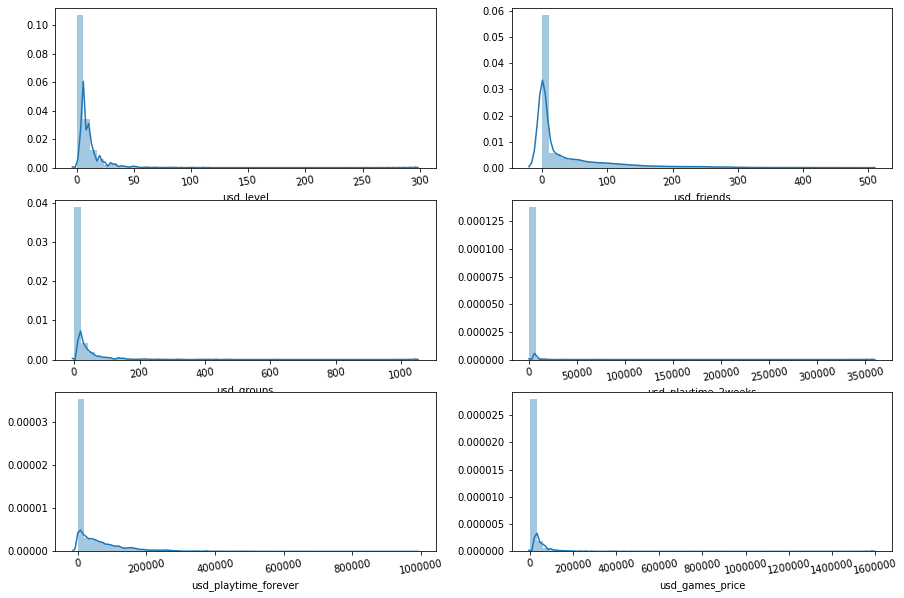

In [ ]:
plt.figure(figsize = (15, 10))

for i, j in enumerate(steam_features):
    plt.subplot(3,2,i+1)
    sns.distplot(df_users[j])
    plt.xticks(rotation = 10)

In this part I group contry_codes by risk level and mark each user to respective risk group.

Country code is extracted from phone number provided by user, but not everyone is obliged to provide it. To fill in the gap ip_last column is used. Applying library IPinfo I extract country code from users' last IPs. I am aware users may use VPN, but hopefully that would still enchance model's performance. As a result, all users without country code are assigned with one. Library provides 50k free IP checks per month, therefore I save acquired data into new csv files. 

In [ ]:
df_users['country_code'].fillna('unknown', inplace = True)

In [ ]:
def ip_address_translator(ip_address): #extracts IP details
    
        ip_object = handler.getDetails(ip_address)

In [ ]:
country_codes_from_ip_df = pd.read_csv('country_by_ip.csv', index_col = 'user_id')

In [ ]:
#while saving country codes there were still duplicated users in df_users, therefore need to remove them.
country_codes_from_ip_df = country_codes_from_ip_df[country_codes_from_ip_df.index.duplicated() != True]

In [ ]:
#adding imported country ocdes to df_users
df_users = pd.merge(df_users, country_codes_from_ip_df['country_code_by_ip'], left_index=True, right_index=True, how = 'left')

#replacing unknown country codes with codes acquired
df_users['country_code_enriched'] = np.where((df_users['country_code'] == 'unknown'), 
                                             df_users['country_code_by_ip'],
                                             df_users['country_code'] )

#removing imported column
df_users.drop(columns = 'country_code_by_ip', inplace = True)

Now I need to enocde countries into readable for model format - 1 and 0. Because there is a great number of countries I group them by common characteristics. To do this, first, I group countries with less than 30 observations as 'Others' making assumption country has to have > 30 observations to consider sample significant, and secondly, I group countries with > 30 observations by relative number of banned users to not banned. As a result three groups are created:

    1) With banned less than 10%
    2) With banned less than 25% and more than 10%
    3) With banned more than 25%
    4) Others

In [ ]:
#creating pivot table to assign risk groups to each country code
countries = pd.pivot_table(df_users, values = 'sex', index = 'country_code_enriched', columns = 'buy_ban', 
                           aggfunc = len, margins = True)

In [ ]:
#removing NaN as not every country has both banned and not banned users.
countries.fillna(0, inplace = True)

#copying index in new column to freely transform country_code into group
countries['groups'] = countries.index

#calculating % of banned users for each country
countries['% of banned'] = countries[1] / countries['All']

In [ ]:
countries['country_group'] = np.where(countries['All'] < 30, 'risk_Others', countries.index)
countries['country_group'] = np.where(((countries['All'] >= 30) & (countries['% of banned'] < 0.1)),
                                      'risk_0_0.1', countries['country_group'])
countries['country_group'] = np.where((countries['All'] >= 30) & (countries['% of banned'] >= 0.1) & (countries['% of banned'] < 0.25) ,
                                      'risk_0.1_0.25', countries['country_group'])
countries['country_group'] = np.where((countries['All'] >= 30) & (countries['% of banned'] >= 0.25),
                                      'risk_0.25_inf', countries['country_group'])

In [ ]:
#mapping country codes to group
countries_mapper = dict(zip(list(countries.index), list(countries.country_group)))

#creating column with country groups assigned for each yser
df_users['country_groups'] = df_users['country_code_enriched'].replace(countries_mapper)

In [ ]:
#creating separate binary features from country_groups
df_users = df_users.join(pd.get_dummies(df_users['country_groups']), on = 'user_id', how = 'left')

In [ ]:
#dropping all columns used for grouping
df_users.drop(columns = ['country_groups','registration_ip','last_ip','country_code_enriched','country_code'], inplace = True)

In [ ]:
#Glance at the table
countries[countries['All'] > 30].sort_values('% of banned', ascending = False).head(10)

buy_ban,0,1,All,groups,% of banned,country_group
country_code_enriched,,,,,,
KZ,105.0,271.0,376,KZ,0.720745,risk_0.25_inf
LV,11.0,28.0,39,LV,0.717949,risk_0.25_inf
RU,328.0,592.0,920,RU,0.643478,risk_0.25_inf
LT,21.0,30.0,51,LT,0.588235,risk_0.25_inf
FI,19.0,15.0,34,FI,0.441176,risk_0.25_inf
US,563.0,327.0,890,US,0.367416,risk_0.25_inf
NO,33.0,15.0,48,NO,0.312500,risk_0.25_inf
All,4990.0,1666.0,6656,All,0.250300,risk_0.25_inf
FR,28.0,8.0,36,FR,0.222222,risk_0.1_0.25


#### Extraction from op_processed

As users are target of analysis, offer postbacks data is used to only enrich df_users data.

In [ ]:
processed_op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003882 entries, 1 to 1164907
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   user_id            1003882 non-null  int64  
 1   op_offer_provider  1003881 non-null  object 
 2   op_type            1003882 non-null  int64  
 3   op_transaction_id  989483 non-null   object 
 4   op_offer_id        987290 non-null   object 
 5   op_offer_name      975941 non-null   object 
 6   op_earned          1003882 non-null  float64
 7   op_signature       1003882 non-null  object 
 8   op_params          1003882 non-null  object 
 9   op_request         1003882 non-null  object 
 10  op_created_at      1003882 non-null  object 
 11  op_updated_at      1003882 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 99.6+ MB


In [ ]:
#short summary of processed_op
print('Number of providers: {}'.format(processed_op['op_offer_provider'].nunique()))
print('Different offer names count: {}'.format(processed_op['op_offer_name'].nunique()))
print('Unique offer ids: {}'.format(processed_op['op_offer_id'].nunique()))
print('Total earned gold net: ${}'.format(round(processed_op['op_earned'].sum()/100, 2)))
print('Total earned gold gross: ${}'.format(round(processed_op[processed_op['op_earned'] > 0]['op_earned'].sum()/100, 2)))
print('Total lost gold: ${}'.format(round(processed_op[processed_op['op_earned'] < 0]['op_earned'].sum()/100, 2)))

#1 G = 0.01 USD

Number of providers: 20
Different offer names count: 10545
Unique offer ids: 35741
Total earned gold net: $175400.25
Total earned gold gross: $187277.4
Total lost gold: $-11877.15


There is important feature which I can add to df_users: op_earned. As a reminder, it shows amount of Gold earned from task. But there are few problems with it. It's data is not always in consistency with other varaible 'op_type'. 

op_type states whether offer was done (denoted by 1) or was chargebacked (denoted by -1),or whether it was inconclusive (neither user was paid nor offer provider paid). 

Incosistency occurs where op_type is -1, but earnings are positive. Explanation is that it is error and it was confirmed by Gainkit that if op_type is -1, then op_earned has to be negative.

To fix this, following logic is used: if op_type is -1, then op_earned set to negative. For cases where op_type = 1 there is no inconsistency, and cases of op_type = 0 are ignored, as it is rather small sample and origined from one offer provider as exception.

In [ ]:
#number of offers by type
processed_op['op_type'].value_counts()

 1    744425
-1    251722
 0      7735
Name: op_type, dtype: int64

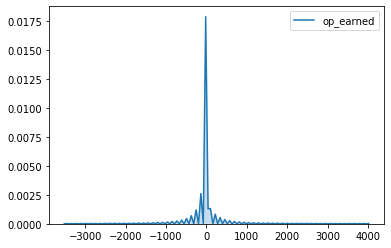

In [ ]:
#chart showing inconsistency of data. It shows only op_earned for op_tpe = -1.
sns.kdeplot(processed_op[processed_op['op_type'] == -1]['op_earned'], shade = True, bw = 5)

In [ ]:
#changing op_earned for op_type "-1" to negative numbers
processed_op.loc[processed_op['op_type'] == -1, 'op_earned'] = processed_op['op_earned'].abs() * -1

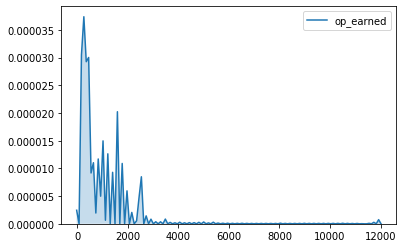

In [ ]:
#This chart shows there is no such problem with op_type = 1.
sns.kdeplot(processed_op[processed_op['op_type'] == 1]['op_earned'], shade = True, bw = 5)

Expectedly, amount of total lost gold increased. as now all chargebacked offers are showing negative earnings.

In [ ]:
#This correction should significantly affect op_earned summaries:
print('Total earned gold netto: ${}'.format(round(processed_op['op_earned'].sum()/100, 2)))
print('Total earned gold gross: ${}'.format(round(processed_op[processed_op['op_earned'] > 0]['op_earned'].sum()/100, 2)))
print('Total lost gold: ${}'.format(round(processed_op[processed_op['op_earned'] < 0]['op_earned'].sum()/100, 2)))

Total earned gold netto: $152062.9
Total earned gold gross: $175608.72
Total lost gold: $-23545.82


In [ ]:
#Below shows what were the earnings from offers with op_type 0, which is only 1 gold (therefore, disregarded)
processed_op[processed_op['op_type'] == 0]['op_earned'].value_counts()

0.0    7734
1.0       1
Name: op_earned, dtype: int64

Next step is to add information about earnings to each user. Effectively, I will simply add net earning and net losses to user.

In [ ]:
#First I create two features in processed_op from op_earned
processed_op['earnings'] = processed_op['op_earned']
processed_op['losses'] = processed_op['op_earned']

#next, offers with negative earnings are set to zero in column 'earnings' and in 'losses' to 0 if earnings are positive.
processed_op.loc[processed_op['earnings'] <= 0, 'earnings'] = 0
processed_op.loc[processed_op['losses'] >= 0, 'losses'] = 0

In [ ]:
#next, using grouby I aggregate earnings for each user
users_earnings = processed_op[['user_id', 'earnings']].groupby('user_id', axis = 0).agg({'earnings': 'sum'})
users_losses = processed_op[['user_id', 'losses']].groupby('user_id', axis = 0).agg({'losses': 'sum'})

#and adding them to the main dataframe
df_users = df_users.join(users_earnings, on = 'user_id', how = 'left')
df_users = df_users.join(users_losses, on = 'user_id', how = 'left')

### Offer providers analysis

This part, though it does not contribute with features to the model, offers useful insight to the offer providers' statistics from offers perspective. Effectively, pivot table is created to show break down of offers by offer providers, in particular:

    1) Number of chargedbacked offers
    2) Number of paid offers
    3) Loss and income
    4) Net income per offer
    5) Weight of provider by net income
    6) Weight of provider by nubmer of offers done

In [ ]:
processed_op['op_id_dummy'] = processed_op.index

#table of offers number by type and offer provider
pt0 = pd.pivot_table(processed_op, values = 'op_id_dummy', aggfunc = lambda x: len(x.unique()),
                     index = ['op_offer_provider'], columns = ['op_type'], margins = True).sort_values(by = -1)

#table of total offers' loss & income by type and offer provider
pt1 = pd.pivot_table(processed_op, values = 'op_earned', aggfunc = np.sum, index = ['op_offer_provider'], columns = ['op_type'], margins = True)
pt1.rename(columns = {'-1': 'Loss', '1': 'OK'}, inplace = True)

#Merging both pivot tables into one
pivot_op = pd.merge(pt0, pt1/100, how = "inner", on = "op_offer_provider").sort_values('-1_y')

# columns 0_y represents earnings for op_type = 0 and does not have any values other than 0, so I drop it
pivot_op.drop('0_y', axis = 1, inplace = True)

#renaming columns
pivot_op.columns = ['# of charged', '0', '# of paid', 'Total #', 'loss', 'income','net']

In [ ]:
#adding useful ratios
pivot_op['net income per offer'] = pivot_op['net']/pivot_op['Total #'] #net income per offer
pivot_op['weight_by_net'] = ((pivot_op['net'] / 152062)*100).round(1)
pivot_op['weight_by_Total #'] = ((pivot_op['Total #'] / 1003881)*100).round(1)

In [ ]:
pivot_op.fillna(0).sort_values('net', ascending = False)

,# of charged,0,# of paid,Total #,loss,income,net,net income per offer,weight_by_net,weight_by_Total #
op_offer_provider,,,,,,,,,,
All,251722.0,7734.0,744425.0,1003881,-23545.8216,175608.7140,152062.8924,0.151475,100.0,100.0
trialpay,0.0,0.0,10529.0,10529,0.0000,54626.1900,54626.1900,5.188165,35.9,1.0
adgatemedia,944.0,0.0,21028.0,21972,-9380.5500,38405.0800,29024.5300,1.320978,19.1,2.2
offertoro,0.0,0.0,119878.0,119878,0.0000,16376.0901,16376.0901,0.136606,10.8,11.9
hangmyads,150.0,0.0,5643.0,5793,-450.6500,11704.0800,11253.4300,1.942591,7.4,0.6
adscendmedia,249270.0,0.0,534131.0,783401,-5232.8100,14598.0900,9365.2800,0.011955,6.2,78.0
personaly,0.0,0.0,6769.0,6769,0.0000,8667.1060,8667.1060,1.280412,5.7,0.7
adworkmedia,486.0,0.0,4803.0,5289,-1255.5100,7737.7200,6482.2100,1.225602,4.3,0.5
peanutlabs,0.0,7734.0,19724.0,27458,0.0000,4773.3580,4773.3580,0.173842,3.1,2.7


**Summary**: Notably, offer providers strongly differ in terms of earned gold per offer. Adscendmedia has the biggest share (78%) of offers done by users, but responsible only for 6.2% of net income. On the opposite, Trialpay has only 1% of share in terms of offers amount, but responsible for 35.9% of the net earnings. Other interesting fact is that there are offer providers with perfect score - they don't have any chargedbacks (and Trailpay is one of them).

That might be usefull to consider promoting one with good chargeback score and perhaps restricting one with the bad one.

## Building models

### Correlation analysis

Before starting building models I would like to see what are the correlations between independent variables and their correlation to dependent variable. 

I will use correlation for both binary and continuous variables, and Chi2 test for binary varaibles. In addition, I will use Light GBM classifier feature importance to help me decide which features might be dropped in case I use model sensetive to multicollinearity.

In [ ]:
X = df_users.drop('buy_ban', axis = 1)
y = df_users['buy_ban'].values

In [ ]:
model = LGBMClassifier(
        num_leaves=31,
        max_depth=-1,
        min_child_samples=10,
        learning_rate=0.06,
        n_estimators=500,
        importance_type = 'gain')

model.fit(X, y)

LGBMClassifier(importance_type='gain', learning_rate=0.06, min_child_samples=10,
               n_estimators=500)

In [ ]:
import lightgbm

Feature importance type is set to "gain", as it would better grasp the contribution of each feature in total.

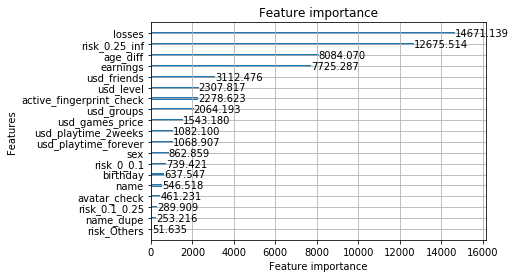

In [ ]:
lightgbm.plot_importance(model, importance_type = 'gain')

#### Chi2 Tests and correlations between binary variables

In [ ]:
#list of binary variables, 10 in total
bi_list = ['name', 'birthday', 'sex', 'name_dupe', 'avatar_check', 'active_fingerprint_check',
           'risk_0.25_inf', 'risk_Others', 'risk_0.1_0.25', 'risk_0_0.1']

Chi2 testing hypothesis are:
    
    H0 - there is no correlation between variables
    H1 - there is correaltion between variables

Goal is to check whether independent variables are not correlated with dependent variable. As a result, tests showed that null hypothesis can be rejected in each case, meaning there could be correlation between dependent and independent variables.

In [ ]:
for i in bi_list:
    ct_for_binaries = pd.crosstab(index = df_users[i], columns = df_users['buy_ban'])
    ChiSqResult = chi2_contingency(ct_for_binaries)
    print(f'{ChiSqResult[1].round(5)} : {i}')

0.0 : name
0.0 : birthday
0.0 : sex
0.0 : name_dupe
0.0 : avatar_check
0.0 : active_fingerprint_check
0.0 : risk_0.25_inf
0.0 : risk_Others
0.0 : risk_0.1_0.25
0.0 : risk_0_0.1


Below loop tests whether independent variables are correlated. All tests except for name and risk_0.25_inf confirm possible correlations. But on the other side, Pearson correlations table shows that most of them are not strongly correlated (corr coef < 0.7), except 2 pairs: name and name_dupe, birthday and sex.

In [ ]:
#Chi2 Tests
for i in bi_list:    # for each variable
    for j in bi_list: # pair with all other variables
        if i == j:  # unless paired to itself
            continue
        else:              # check whether p-value of Chi2 Test for particular pair is less than 0.05 
            ct_for_binaries = pd.crosstab(index = df_users[i], columns = df_users[j])
            ChiSqResult = chi2_contingency(ct_for_binaries)
            if ChiSqResult[1] > 0.05:               
                print(f' {i} and {j} : {ChiSqResult[1]}')

 name and risk_0.25_inf : 0.5273749097688972
 risk_0.25_inf and name : 0.5273749097688972


In [ ]:
#identifying highly correlated (Pearson) features (corr coef > 0.7)

corr = df_users[bi_list].corr()

highly_correlated_features = set()
for i in corr.index:
    for j in corr.columns:
        if abs(corr.loc[i, j]) == 1:
            continue
        elif abs(corr.loc[i, j]) > 0.7:
            if (j, i) in highly_correlated_features:
                continue
            else:
                highly_correlated_features.add((i, j))
        else:
            continue

print(list(highly_correlated_features))

[('name', 'name_dupe'), ('birthday', 'sex')]


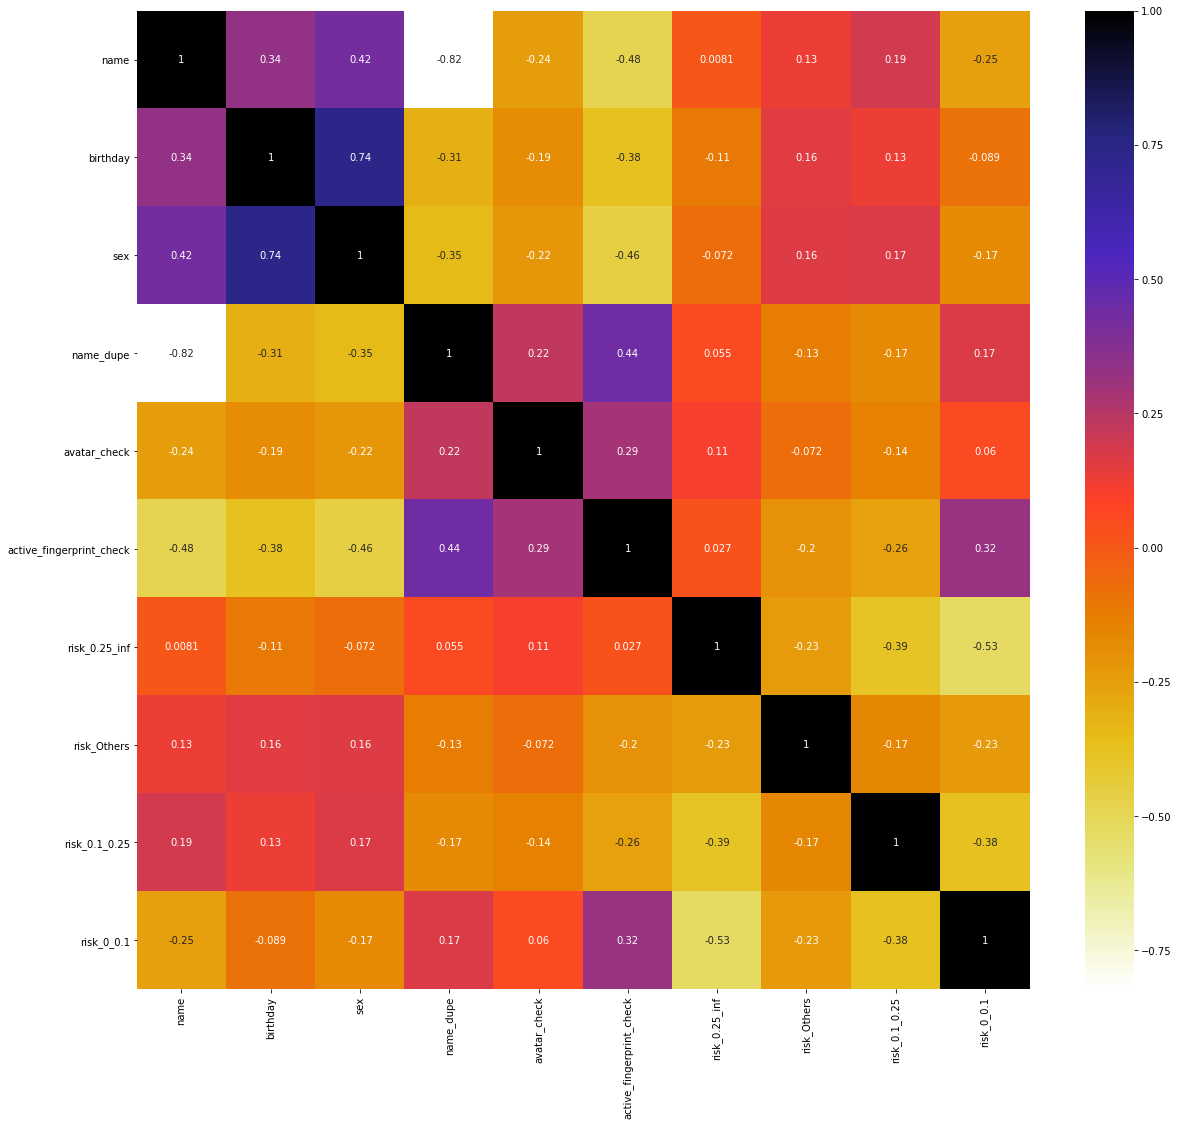

In [ ]:
#Pearson correlation table
plt.figure(figsize=(20,18),)
cor = df_users[bi_list].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, )
plt.show()

#### Correlation between continuous variables

In [ ]:
#in total 9 variables are continuous
cont_list = list(df_users.drop(bi_list, axis = 1).columns)

To explore continuous variables I use both Spearman and Pearson correlations. As it appears, almost every variable has monotonic relationship with the target variable. Same applies for the correlations between independent variables. It is signficiantly stronger when analyzed with Spearman correlation.

In [ ]:
print('---------------Spearman---------------')
print(df_users[cont_list].corr('spearman')['buy_ban'])
print()
print('---------------Pearson---------------')
print(df_users[cont_list].corr()['buy_ban'])

---------------Spearman---------------
buy_ban                 1.000000
usd_level              -0.093364
usd_friends            -0.109815
usd_groups             -0.104102
usd_playtime_2weeks    -0.063160
usd_playtime_forever   -0.058223
usd_games_price        -0.079017
age_diff                0.103447
earnings                0.318424
losses                 -0.526685
Name: buy_ban, dtype: float64

---------------Pearson---------------
buy_ban                 1.000000
usd_level              -0.038331
usd_friends            -0.025442
usd_groups             -0.032784
usd_playtime_2weeks     0.010772
usd_playtime_forever   -0.002036
usd_games_price        -0.018250
age_diff                0.008462
earnings                0.114932
losses                 -0.271509
Name: buy_ban, dtype: float64


Monotonic relationships between Steam details are very high. That makes sense. As user spends more time there is a good chance user will get greater level, more friends, subscribe to groups, play more time and purchase more games. Also earnings and loss are negatively correlated. In most cases probably the more user makes offers, the more are the chances chargeback would occur.

In [ ]:
#identifying highly correlated features (corr coef > 0.9)

corr = df_users[cont_list].corr('spearman')

highly_correlated_features = set()
for i in corr.index:
    for j in corr.columns:
        if abs(corr.loc[i, j]) == 1:
            continue
        elif abs(corr.loc[i, j]) > 0.9:
            if (j, i) in highly_correlated_features:
                continue
            else:
                if (j, i) in highly_correlated_features:
                    continue
                else:
                    highly_correlated_features.add((i, j))
        else:
            continue

print(list(highly_correlated_features))

[('usd_playtime_forever', 'usd_games_price')]


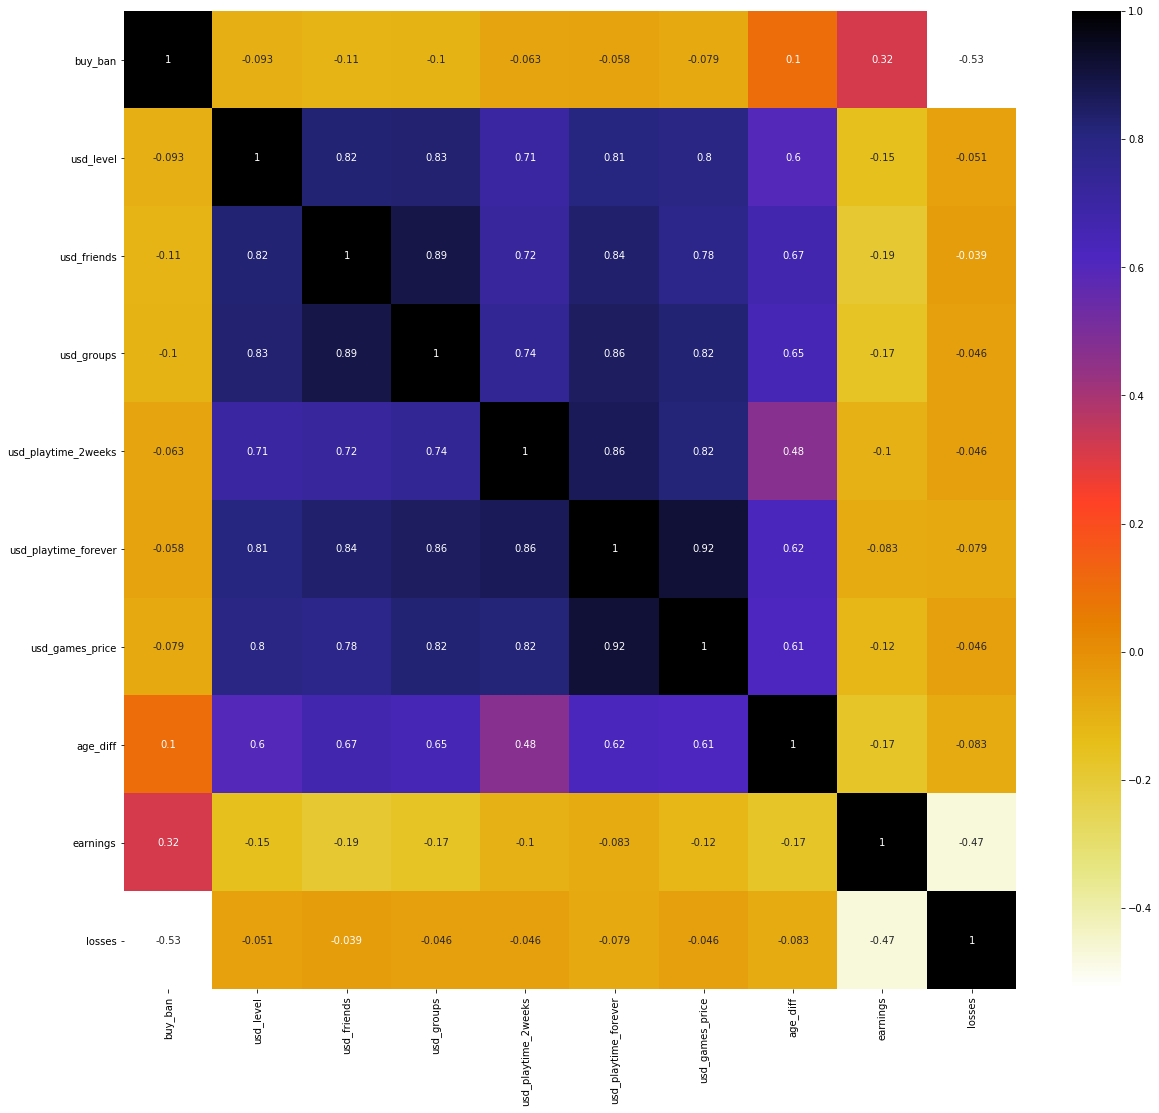

In [ ]:
plt.figure(figsize=(20,18),)
cor = df_users[cont_list].corr('spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, )
plt.show()

### Tuning hyperparameters for models

In [ ]:
#Splitting into train-test datasets. Test sample is set to be 20%.
X = df_users.drop('buy_ban', axis = 1).values 
Y = df_users['buy_ban'].values

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

I am going to take advantage of relatively small dataset and try to apply several models and combine them. In addition, it allows to easily leverage GridSearch for hyperparameters tuning.

Tried models:

    1) Random Forest Classifier
    2) Gradient Boosting Classifier
    3) LGBM Classifier
    4) XGBoost
    5) Combined model

Besides maximizing accuracy, goal is to maximize recall parameter, because I want model to be biased towards banning rather than not banning. Business reasoning is that cost of unbanning users or losing user because of wrongly banning is much lower than cost of fraud activity. In short, better ban more than less.

#### Random Forest Classifier

Parameters to tune are:

    1) Number of estimators
    2) Max depth  
    3) Minimum number of samples for split
    
Result: GridSearch identified folowing best model parameters among 280 combinations:

    'max_depth': 10,
    'min_samples_split': 10,
    'n_estimators': 80

In [ ]:
forest = RandomForestClassifier()

gs_rfc = GridSearchCV(estimator=forest, 
             param_grid={'n_estimators': [10, 20, 30, 50, 60, 80, 100], 'max_depth': [4, 5, 6, 8, 10, 15, 20, 25, 30, None],
                        'min_samples_split': [10, 50, 100, 200]}, 
             scoring='recall', n_jobs = 2,
             cv=cv
             )

In [ ]:
gs_rfc_results = gs_rfc.fit(X_train, Y_train)

In [ ]:
gs_rfc_results.best_params_

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 60}

In [ ]:
pd.DataFrame(gs_rfc_results.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
116,0.334122,0.013002,0.020731,0.000747,10,10,60,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.796296,0.830258,0.767528,0.804428,0.833333,0.806369,0.024132,1
108,0.223280,0.005840,0.011740,0.003211,8,200,50,"{'max_depth': 8, 'min_samples_split': 200, 'n_...",0.811111,0.815498,0.785978,0.793358,0.814815,0.804152,0.012146,2
88,0.304807,0.009039,0.018703,0.003265,8,10,60,"{'max_depth': 8, 'min_samples_split': 10, 'n_e...",0.792593,0.833948,0.778598,0.800738,0.814815,0.804138,0.018973,3


Testing RFC with the best parameters on the test sample

In [ ]:
rfc = RandomForestClassifier(n_estimators = 60, min_samples_split = 10, max_depth = 10,
                                    random_state = 50)
model_rfc = rfc.fit(X_train, Y_train)    

In [ ]:
cm = confusion_matrix(Y_test, model_rfc.predict(X_test)) 
TN, FP, FN, TP = confusion_matrix(Y_test, model_rfc.predict(X_test)).ravel()
print(cm)
print('RFC Testing Accuracy = "{} !"'.format((TP + TN) / (TP + TN + FN + FP)))

[[964  55]
 [ 56 257]]
RFC Testing Accuracy = "0.9166666666666666 !"


#### Gradient Boosting Classifier

Parameters to tune are:

    1) Learning Rate
    2) Number of boosting stages
    3) Minimum number of samples required for split
    4) Maximum depth

Result: GridSearch identified folowing best model parameters among 64 combinations: 

    'learning_rate': 0.1,
     'max_depth': None,
     'min_samples_split': 25,
     'n_estimators': 50

In [ ]:
gbc = GradientBoostingClassifier(random_state = 50)

gs_gbc = GridSearchCV(estimator=gbc, 
             param_grid={'learning_rate': [0.01, .02, .05, .1], 'n_estimators': [50, 100],
                        'min_samples_split': [10, 25], 'max_depth': [10, 15, 20, None]}, 
             scoring='recall', n_jobs = 2,
             cv=cv
             )

In [ ]:
gs_gbc_results = gs_gbc.fit(X_train, Y_train)

In [ ]:
gs_gbc_results.best_params_

{'learning_rate': 0.1,
 'max_depth': None,
 'min_samples_split': 25,
 'n_estimators': 50}

In [ ]:
gs_gbc_results.best_score_

0.8189257892578926

In [ ]:
pd.DataFrame(gs_gbc_results.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
62,2.077189,0.091472,0.007668,0.000584,0.1,None,25,50,"{'learning_rate': 0.1, 'max_depth': None, 'min...",0.811111,0.845018,0.774908,0.830258,0.833333,0.818926,0.024558,1
39,2.576833,0.018038,0.008570,0.000481,0.05,15,25,100,"{'learning_rate': 0.05, 'max_depth': 15, 'min_...",0.814815,0.833948,0.774908,0.826568,0.837037,0.817455,0.022609,2
63,5.032117,0.156066,0.015374,0.000446,0.1,None,25,100,"{'learning_rate': 0.1, 'max_depth': None, 'min...",0.807407,0.837638,0.782288,0.819188,0.837037,0.816712,0.020634,3


Testing GBC with best parameters on the test sample

In [ ]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 50, min_samples_split = 25, max_depth = None,
                                    random_state = 50)
model_gbm = gbc.fit(X_train, Y_train)    

In [ ]:
cm = confusion_matrix(Y_test, model_gbm.predict(X_test)) 
TN, FP, FN, TP = confusion_matrix(Y_test, model_gbm.predict(X_test)).ravel()
print(cm)
print('GBM Testing Accuracy = "{} !"'.format((TP + TN) / (TP + TN + FN + FP)))
print() # Print a new line

[[961  58]
 [ 52 261]]
GBM Testing Accuracy = "0.9174174174174174 !"



#### LGBM Classifier

Parameters to tune are:

    1) Learning Rate
    2) Maximum depth

Result: GridSearch identified folowing best model parameters:

    'learning_rate': 0.13,
    'max_depth': 10


In [ ]:
lgbm = LGBMClassifier(min_child_samples = 10, random_state = 50)

gs_lgbm = GridSearchCV(estimator=gbc, 
             param_grid={'learning_rate': np.arange(0.09, 0.15, 0.01),
                         'max_depth': [10, 15] 
                        }, 
             scoring='recall', n_jobs = 2,
             cv=cv
             )       

In [ ]:
gs_lgbm_results = gs_lgbm.fit(X_train, Y_train)

In [ ]:
gs_lgbm_results.best_params_

{'learning_rate': 0.12999999999999998, 'max_depth': 10}

In [ ]:
gs_lgbm_results.best_score_

0.8182014486811535

In [ ]:
pd.DataFrame(gs_lgbm_results.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.915616,0.012623,0.003393,0.000490,0.13,10,"{'learning_rate': 0.12999999999999998, 'max_de...",0.825926,0.837638,0.782288,0.808118,0.837037,0.818201,0.020898,1
4,0.911983,0.011869,0.003618,0.000476,0.11,10,"{'learning_rate': 0.10999999999999999, 'max_de...",0.811111,0.841328,0.771218,0.819188,0.848148,0.818199,0.027168,2
0,0.944915,0.030559,0.003990,0.000001,0.09,10,"{'learning_rate': 0.09, 'max_depth': 10}",0.814815,0.837638,0.778598,0.819188,0.833333,0.816715,0.020864,3


Testing LGBM with best parameters on the test sample

In [ ]:
model_LGBM = LGBMClassifier(
        learning_rate = 0.13,        
        min_child_samples=10,
        max_depth = 10,
        n_estimators=300)

model_LGBM = model_LGBM.fit(X_train, Y_train)

In [ ]:
cm = confusion_matrix(Y_test, model_LGBM.predict(X_test)) 
TN, FP, FN, TP = confusion_matrix(Y_test, model_LGBM.predict(X_test)).ravel()
print(cm)
print('LGBM Testing Accuracy = "{} !"'.format((TP + TN) / (TP + TN + FN + FP)))
print() # Print a new line

[[979  40]
 [ 48 265]]
LGBM Testing Accuracy = "0.933933933933934 !"



#### XGBoost Classifier

Parameters to tune are:

    1) Learning Rate
    2) Max Depth
    3) Objective

Result: GridSearch identified folowing best model parameters: 

    'learning_rate': 0.18, 
    'max_depth': 7, 
    'objective': 'binary:logistic'

In [ ]:
xgb = xgboost.sklearn.XGBClassifier(nthread=-1, use_label_encoder=False, seed=50)

gs_xgb = GridSearchCV(estimator=xgb, 
             param_grid={'learning_rate': np.arange(0.15, 0.25, 0.01), 'max_depth' : range(5,11),
                         'objective' : ['binary:logistic', 'binary:hinge']
                        }, 
             scoring='recall', n_jobs = 2,
             cv=cv
             )       

In [ ]:
gs_xgb_results = gs_xgb.fit(X_train, Y_train)

[21:46:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
gs_xgb_results.best_params_

{'learning_rate': 0.18000000000000002,
 'max_depth': 7,
 'objective': 'binary:logistic'}

In [ ]:
gs_xgb_results.best_score_

0.8204018040180401

In [ ]:
pd.DataFrame(gs_xgb_results.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_objective,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.417594,0.011746,0.003592,0.000490,0.18,7,binary:logistic,"{'learning_rate': 0.18000000000000002, 'max_de...",0.800000,0.841328,0.800738,0.815498,0.844444,0.820402,0.019199,1
1,0.295879,0.006088,0.003391,0.000489,0.15,5,binary:hinge,"{'learning_rate': 0.15, 'max_depth': 5, 'objec...",0.811111,0.837638,0.771218,0.826568,0.851852,0.819677,0.027666,2
6,0.441547,0.008482,0.003797,0.000402,0.15,8,binary:logistic,"{'learning_rate': 0.15, 'max_depth': 8, 'objec...",0.800000,0.833948,0.800738,0.811808,0.837037,0.816706,0.015929,3


In [ ]:
model_xgb = xgboost.XGBClassifier(objective="binary:logistic", use_label_encoder = False, random_state=50, learning_rate = 0.18,
                                 max_depth = 7)

In [ ]:
model_xgb.fit(X_train, Y_train)

[21:47:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.18, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=50,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
cm = confusion_matrix(Y_test, model_xgb.predict(X_test)) 
TN, FP, FN, TP = confusion_matrix(Y_test, model_xgb.predict(X_test)).ravel()
print(cm)
print('XGBoost Testing Accuracy = "{} !"'.format((TP + TN) / (TP + TN + FN + FP)))

[[972  47]
 [ 47 266]]
XGBoost Testing Accuracy = "0.9294294294294294 !"


#### Combined Model

Combined model is a simple combination of previous models' predictive powers. It has only one hyperparameter - how many votes are required to ban user. There are two scenarios:

    1) At least one vote for ban is required to ban
    2) At least two votes for ban are required to ban

Expectation is that this will bias model towards banning rather than not banning without decreased accuracy.

As a result, combined model with minimum 1 vote to ban is inclined to ban more than allow abusive users go unpunished . Fortunately, without significant loss of accuracy.

In [ ]:
#predictions of original models
lgbm_results = model_LGBM.predict(X_test)
rfc_results = model_rfc.predict(X_test)
gbm_results = model_gbm.predict(X_test)
xgboost_results = model_xgb.predict(X_test)

In [ ]:
#running two scenarios

for i in [2, 1]:
    
    #table with perdiction results
    results_comparison = pd.DataFrame(data = {'lgbm' : lgbm_results,'rfc': rfc_results, 'gbm': gbm_results, 'xgb' :xgboost_results})

    #creating predictions with one vote enough to ban
    results_comparison['vote'] = np.where(results_comparison.sum(axis = 1) >= i, 1, 0)
    
    #results
    cm = confusion_matrix(Y_test, results_comparison['vote']) 
    TN, FP, FN, TP = confusion_matrix(Y_test, results_comparison['vote']).ravel()
    print(f'------------ [Ban if vote to ban > = {i}] ------------')
    print(cm)
    print('XGBoost Testing Accuracy = "{} !"'.format((TP + TN) / (TP + TN + FN + FP)))
    print()

------------ [Ban if vote to ban > = 2] ------------
[[967  52]
 [ 44 269]]
XGBoost Testing Accuracy = "0.9279279279279279 !"

------------ [Ban if vote to ban > = 1] ------------
[[942  77]
 [ 29 284]]
XGBoost Testing Accuracy = "0.9204204204204204 !"



### Models summary

All 5 models have very similar results. Accuracy score in each case is around 0.92, ROC-AUC score is in range 0.88 - 0.91. But recall score in combined model is significantly better. While original models' recall score vary in range 0.82 to 0.84, combined model showed result of 0.88. However, it comes at a price. For original models precision varies in range from 0.81 to 0.87, while combined model's precision is 0.79. Despite this, from business perspective higher recall is much favorable than higher precision.

In [ ]:
#results columns
lgbm_results = model_LGBM.predict(X_test)
rfc_results = model_rfc.predict(X_test)
gbm_results = model_gbm.predict(X_test)
xgboost_results = model_xgb.predict(X_test)

#table with perdiction results for combined model
results_comparison = pd.DataFrame(data = {'lgbm' : lgbm_results,'rfc': rfc_results, 'gbm': gbm_results, 'xgb' :xgboost_results})

#adding combined model results
results_comparison['vote'] = np.where(results_comparison.sum(axis = 1) >= 1, 1, 0)

In [ ]:
#data for plotting scores
recall_summary = []
roc_auc_summary = []
accuracy_score_summary = []
precision_summary = []

model_name = ['lgbm', 'gbm', 'rfc', 'xgb', 'vote']
for i in model_name:    
    recall_summary.append(recall_score(Y_test, results_comparison[i]))
    roc_auc_summary.append(roc_auc_score(Y_test, results_comparison[i]))
    accuracy_score_summary.append(accuracy_score(Y_test, results_comparison[i]))
    precision_summary.append(precision_score(Y_test, results_comparison[i]))

In [ ]:
#Summary table for scores
pd.DataFrame({'Recall': recall_summary, 'ROC AUC': roc_auc_summary, 'Accuracy': accuracy_score_summary,
             'Precision': precision_summary}, index = model_name)

,Recall,ROC AUC,Accuracy,Precision
lgbm,0.846645,0.903696,0.933934,0.868852
gbm,0.833866,0.888474,0.917417,0.818182
rfc,0.821086,0.883556,0.916667,0.823718
xgb,0.849840,0.901858,0.929429,0.849840
vote,0.907348,0.915892,0.920420,0.786704


Text(0.5, 1.0, 'Recall Score')

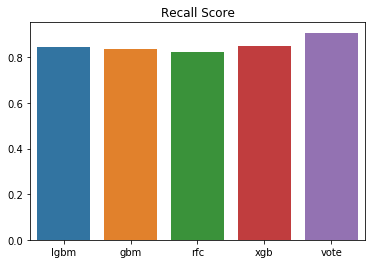

In [ ]:
sns.barplot(x = model_name, y = recall_summary).set_title('Recall Score')

Text(0.5, 1.0, 'ROC-AUC Score')

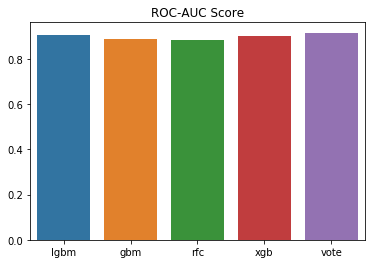

In [ ]:
sns.barplot(x = model_name, y = roc_auc_summary).set_title('ROC-AUC Score')

Text(0.5, 1.0, 'Accuracy Score')

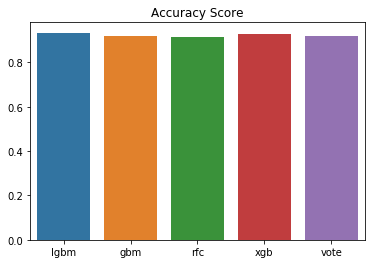

In [ ]:
sns.barplot(x = model_name, y = accuracy_score_summary).set_title('Accuracy Score')

Text(0.5, 1.0, 'Precision Score')

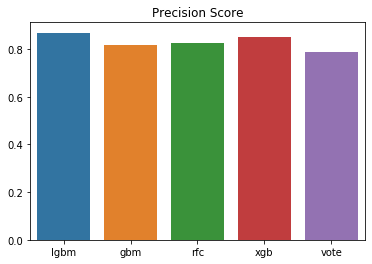

In [ ]:
sns.barplot(x = model_name, y = precision_summary).set_title('Precision Score')

In [ ]:
#classification report for each case
for i in ['lgbm', 'gbm', 'rfc', 'xgb', 'vote']:
    print(f'----------------   {i}   ------------------')
    print(classification_report(Y_test, results_comparison[i]))

----------------   lgbm   ------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1019
           1       0.87      0.85      0.86       313

    accuracy                           0.93      1332
   macro avg       0.91      0.90      0.91      1332
weighted avg       0.93      0.93      0.93      1332

----------------   gbm   ------------------
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1019
           1       0.82      0.83      0.83       313

    accuracy                           0.92      1332
   macro avg       0.88      0.89      0.89      1332
weighted avg       0.92      0.92      0.92      1332

----------------   rfc   ------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1019
           1       0.82      0.82      0.82       313

    accuracy                           0.92      

## Conclusion

**Exploratory analysis and features engineering**

In total there were 57 features from 3 datasets provided by Gainkit.com. After data exploratory analysis and feature engineering it was decided to apply following 19 features for modelling:

Binary features:

    1) name - did user sepcify name?
    2) birthday - date of birthday - did user specify birthday date?
    3) sex - did user specified sex?
    4) name_dupe - was user's name re-used?
    5) avatar_check - does user share same avatar with other user?
    6) active_fingerprint_check - does user's unique figerprint was shared with another user? 
    7) risk_0.1_0.25 - is user from country which belongs to the moderate risk countries group?
    8) risk_0.25_inf - is user from country which belongs to the high risk countries group?
    9) risk_0_0.1 - is user from country which belongs to low risk countries group?
    10) risk_Others - identifies whether user is from country with low users sample 

Continuous features:

    1) usd_level - user's level in Steam
    2) usd_friends - number of friends in Steam
    3) usd_playtime_2weeks - how much time user spent playing in Steam during last two weeks
    4) usd_playtime_forever - how much time user spent playing in Steam in total
    5) usd_games_price - how much user spent money on games in Steam
    6) usd_groups - to how many groups user is subscribed
    7) age_diff - how old was user's Steam account when Gainkit account was created
    8) earnings - how much money user earned doing tasks
    9) losses - how much money was chargedback as a result of user doing offers 
    
**Correlations**

During correlation analysis of binary variables, Chi2 Tests and correlation coefficients were used.
Chi2 tests showed that all binary variables might be correlated with target variable. Also Chi2 tests indicated that independent variables could be correlated as well. That was confirmed by analysis of correlation coefficient, but strong relationship (corr. coef. > 0.7) was indicated only between: name and name_dupe, birthday and sex.

Correlations analysis of Steam variables showed that correlation is much stronger when described by Spearman correlation. This identifies that Steam variables have monotonic relationship between themselves. 
Age_diff showed weaker, but still significant correlation with Steam variables (ca. 0.6) and weak correlation with earnings and losses.
Earnings and lossess presented weak correlation with other variables, but are negatively correlated with each other. Assumption is that the more users complete offers, the more chargedbacks happen on their account.

All variables demonstrated rather weak correlation with target variable and there is good evidence that many independent variables demonstrate multicolinearity.

**Building models**

During modelling process there were 5 models created. All of them are tree-based, therefore, have a good resilience to outliers, multicolinearity and can handle bigger number of variables. Those models are:

    1) Random Forest Classifier
    2) Gradient Boosting Classifier
    3) LGBM Classifier
    4) XGBoost Classifier
    5) Combined Model

Because sample used in analysis is rather small (6656 observations), SKLearn CVGridSearch was applied for tuning of hyperparameters it was decided to use following parameters in each model (except last one):

    1) RFC - 280 hyperparametes combinations: max_depth = 10, min_samples_split = 10, n_estimators = 80
    2) Gradient Boosing Classifier - 64 hyperparametes combinations: learning_rate = 0.1, max_depth = None, min_samples_split = 25, n_estimators = 50
    3) LGBM Classifier - 8 hyperparametes combinations: learning_rate = 0.13,  max_depth = 10
    4) XGBoost Classifier -30 hyperparametes combinations: learning_rate = 0.18,  max_depth = 7, objective = 'binary:logistic'

Combined model was created using other 4 models. Applying their predictions it decides what should be it's prediction. Because for Gainkit it is more preferable to have more False Positives rather than False Negatives, it predicts user should be banned if at least one of four models predicted user has to be banned. As a result, it does not have the best accuracy, but considering other scoring metrics such as ROC AUC and Recall it outperforms other models.

On the other side, implementation of such model is more costly, as it implies usage of all 4 models simultaneously. Because all 4 models have rather good efficiency, it is up to Gainkit.com to decide which models suits best. Although, considering preferences, the best solution is combined model.

**Further considerations**

First, there are still many variables to utilize in the website's database. One of the directions is to try utilize and expand analysis of Offer Providers statistics done in part 1.1.4. 

Second, another direction to consider is to use neural networks like MLP classifier or Logistic Regression for prediction. It would require  deeper work on features processing and selection, but they might have higher efficiency or be good contributers to combined models.

Third, there is opportunity for creation of classification models which would have op_type (which identifies whether offer was chardgeback or not) as a target variable. As separate model or addition to the prepared one in this project it might help identify whether offer will be chargebacked.

Fourth, rather next step than consideration: create pipeline for current model and develop strategy for model's learning after deployment. 